In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.constants as cts
import pylcp
import time

In [2]:
Gamma = 22 # MHz, Decay rate
k = 1/359.3*1e9*2*np.pi #x_0
x0 = 1/k # meter
t0 = 1/Gamma*1/(2*np.pi*1e6) # second
v0 = x0/t0 # m/s
m0 = cts.hbar*t0/x0**2 # kg
a0 = x0/t0**2 # m/s^2
F0 = cts.hbar/(x0*t0) # kg*m/s^2
mass = 43*cts.value('atomic mass constant')/m0 # m_0
waist = 12
mag_field_grad = 1 #G/m
v_max = 4
z_max = 20 # meter
wavelength = 359.3e-9

H0_X, Bq_X, U_X, Xbasis = pylcp.hamiltonians.XFmolecules.Xstate(B=0,
gamma = 50.697/Gamma,b=154.7/Gamma, c=178.5/Gamma,
    muB = cts.value('Bohr magneton in Hz/T')/1e6*1e-4/Gamma,return_basis=True
    )

# b : SI coupling(isotropic), c : Iz Sz coupling(anisotropic), cc : I N coupling, gamma : S N coupling

E_X = np.unique(np.diag(H0_X))

H0_A, Bq_A, Abasis = pylcp.hamiltonians.XFmolecules.Astate(
    P=+1, Ahfs=2.4/Gamma, q=0, p=0,
    muB=cts.value('Bohr magneton in Hz/T')/1e6*1e-4/Gamma, return_basis=True
    )

# gJ : Lande g-factor, p : parity(e parity)

E_A = np.unique(np.diag(H0_A))

dijq = pylcp.hamiltonians.XFmolecules.dipoleXandAstates(
    Xbasis, Abasis, UX=U_X
    )

hamiltonian = pylcp.hamiltonian(H0_X, H0_A, Bq_X, Bq_A, dijq,mass = mass)

In [3]:
Isat = np.pi*cts.h*cts.c*Gamma*2*np.pi*1e6/3*1/(wavelength)**3

magField = pylcp.quadrupoleMagneticField(mag_field_grad)

def Fixed_detune_MgF_MOT(s):
    laserBeams = pylcp.laserBeams()
    for ii, Eg_i in enumerate(E_X):
        if ii<2:
            laserBeams += pylcp.conventional3DMOTBeams(
                s=s, delta=(E_A[-1] - Eg_i)-0.5, pol=+1,wb=waist,
                beam_type=pylcp.gaussianBeam
                )
        elif ii==2:
            laserBeams += pylcp.conventional3DMOTBeams(
                s=s, delta=(E_A[-1] - E_X[3])-0.15,pol=+1,wb=waist,
                beam_type=pylcp.gaussianBeam
                )
        else:
            laserBeams += pylcp.conventional3DMOTBeams(
                s=s, delta=(E_A[-1] - Eg_i)-0.5, pol=-1,wb=waist,
                beam_type=pylcp.gaussianBeam
                )

    return laserBeams

def Fixed_detune_MgF_MOT2(s):
    laserBeams = pylcp.laserBeams()
    for ii, Eg_i in enumerate(E_X):
        if ii<1:
            laserBeams += pylcp.conventional3DMOTBeams(
                s=s, delta=(E_A[-1] - Eg_i)-0.5, pol=+1,wb=1.2,
                beam_type=pylcp.gaussianBeam
                )
        if ii==1:
            laserBeams += pylcp.conventional3DMOTBeams(
                s=s, delta=(E_A[-1] - Eg_i)-0.5, pol=+1,wb=1.2,
                beam_type=pylcp.gaussianBeam
                )
        elif ii==2:
            laserBeams += pylcp.conventional3DMOTBeams(
                s=s, delta=(E_A[-1] - E_X[3])-0.15,pol=+1,wb=1.2,
                beam_type=pylcp.gaussianBeam
                )
        else:
            laserBeams += pylcp.conventional3DMOTBeams(
                s=s, delta=(E_A[-1] - Eg_i)-0.5, pol=-1,wb=12,
                beam_type=pylcp.gaussianBeam
                )

    return laserBeams

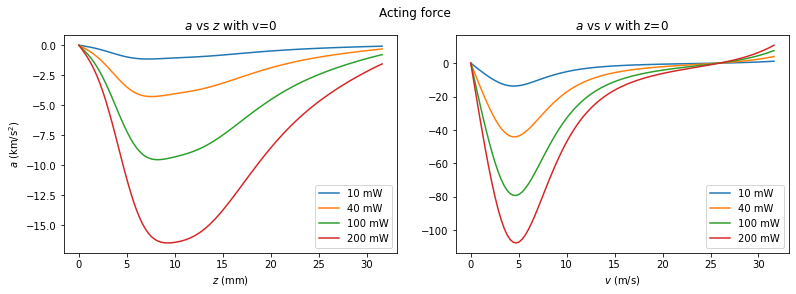

In [4]:
# The detunings used in the PRAs:
dets = np.array([-0.25, -0.5, -1, -2])
P = np.array([0.010, 0.040, 0.1, 0.2])
intensities = 2.*P/(np.pi*0.012**2)/Isat
# Make the axis:
z = np.linspace(0, 50, 101)
v = np.linspace(0., 4., 101)

fig,ax = plt.subplots(1,2,figsize=(13,4))    
for jj, intensity in enumerate(intensities):
    laserBeams = Fixed_detune_MgF_MOT(intensity)
    trap = pylcp.rateeq(laserBeams,magField,hamiltonian,include_mag_forces=0)
    trap.generate_force_profile(
        [np.zeros(z.shape), np.zeros(z.shape), z],
        [np.zeros(z.shape), np.zeros(z.shape), np.zeros(z.shape)],
        name='Fz')
    trap.generate_force_profile(
        [np.zeros(v.shape), np.zeros(v.shape), 0*np.ones(v.shape)],
        [np.zeros(v.shape), np.zeros(v.shape), v],
        name='Fv')
    ax[0].plot(v*x0/t0, trap.profile['Fz'].F[2]/mass*x0/t0**2*1e-3, color='C{0:d}'.format(jj),label = f'{int(1000*P[jj])} mW')
    ax[1].plot(v*x0/t0, trap.profile['Fv'].F[2]/mass*x0/t0**2*1e-3, color='C{0:d}'.format(jj),label = f'{int(1000*P[jj])} mW')
ax[0].set_xlabel('$z\ (\mathrm{mm})$')
ax[0].set_ylabel('$a\ (\mathrm{km/s^2})$')
ax[0].set_title('$a$ vs $z$ with v=0')
ax[1].set_xlabel('$v\ (\mathrm{m/s})$')
ax[1].set_title('$a\ \mathrm{vs}\ v$ with z=0')
ax[0].legend()
ax[1].legend()
fig.suptitle('Acting force')
fig.subplots_adjust(hspace=0.33, wspace=0.175)

fig.savefig('./picture/20210614_1.png')

In [9]:
m0*a0/F0

0.9999999999999998